# From the address to the 3D

In [26]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import geopy as gp
import folium

from shapely.geometry import Point

import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import mayavi

In [9]:
from functions import *

## Enter an address, get a location

In [5]:
# Google API (quand compte ok)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.geocoders.GoogleV3(api_key='')
    location = locator.geocode(address, timeout=10)
    print(location.raw)
    print(location.address)
    postcode = location.address['postcode']
    country_code = location.address['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[1], coord[0], postcode))

Please, enter an address in Begium:
Gare de Namur


<ipython-input-5-f8019876c1a0>:8: UserWarning: Since July 2018 Google requires each request to have an API key. Pass a valid `api_key` to GoogleV3 geocoder to hide this warning. See https://developers.google.com/maps/documentation/geocoding/usage-and-billing
  locator = gp.geocoders.GoogleV3(api_key='')


GeocoderUnavailable: HTTPSConnectionPool(host='maps.googleapis.com', port=443): Max retries exceeded with url: /maps/api/geocode/json?sensor=false&address=Gare+de+Namur (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020A5EBF2430>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [10]:
# OpenStreet Map (gratuit, moins efficace)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address, addressdetails=True)
    
    postcode = int(location.raw['address']['postcode'])
    country_code = location.raw['address']['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[0], coord[1], postcode))

Please, enter an address in Begium:
Gare de Namur
Latitude = 50.469100100000006, Longitude = 4.862421313946799, Postcode = 5000


In [11]:
mappy = folium.Map(
    location=[coord[0],coord[1]],
    zoom_start=17
)

folium.CircleMarker(
    location=[coord[0],coord[1]],
    radius=30,
    popup='Your address',
    color='#3186cc',
    fill=True,
    fill_color='#3186cc'
).add_to(mappy)

mappy

## Get the corrects LiDAR files' path

In [12]:
path_dsm = ""
path_dtm = ""
flanders = False

if postcode >= 1300 and postcode < 1500:
    path_dsm = set_path_dsm('BRABANT_WALLON')
    path_dtm = set_path_dtm('BRABANT_WALLON')
    print('Walloon Brabant')
    
elif postcode >= 4000 and postcode < 5000:
    path_dsm = set_path_dsm('LIEGE')
    path_dtm = set_path_dtm('LIEGE')
    print('Liège')
    
elif postcode >= 5000 and postcode < 6000:
    path_dsm = set_path_dsm('NAMUR')
    path_dtm = set_path_dtm('NAMUR')
    print('Namur')
    
elif (postcode >= 6000 and postcode < 6600) or (postcode >= 7000 and postcode < 8000):
    path_dsm = set_path_dsm('HAINAUT')
    path_dtm = set_path_dtm('HAINAUT')
    print('Hainaut')
    
elif postcode >= 6600 and postcode < 7000:
    path_dsm = set_path_dsm('LUXEMBOURG')
    path_dtm = set_path_dtm('LUXEMBOURG')
    print('Luxembourg')
    
else:
    number = [x for x in range(1, 44)]
    for i in number :
        pass
    flanders = True
    print('Brussels or Flanders region')

Namur


## From coordinates to correct crs

In [13]:
# Walloon region uses EPSG:31370
# Flanders region uses EPSG:?

if flanders == False:
    p = gpd.GeoSeries([Point(coord[1], coord[0])])
    p.crs = 'epsg:4326'
    p = p.to_crs(epsg=31370)
    print(p[0])
else:
    pass



POINT (185046.4410823517 128813.7578461301)


## Get a sample of the LiDARs, center on the coordinates

##### DSM

/home/morgane/Documents/Resources/Wallonia/DSM 2013-2014/RELIEF_WALLONIE_MNS_2013_2014_GEOTIFF_31370_PROV_NAMUR/RELIEF_WALLONIE_MNS_2013_2014.tif
Pixel Y, X coords: 21186, 41046


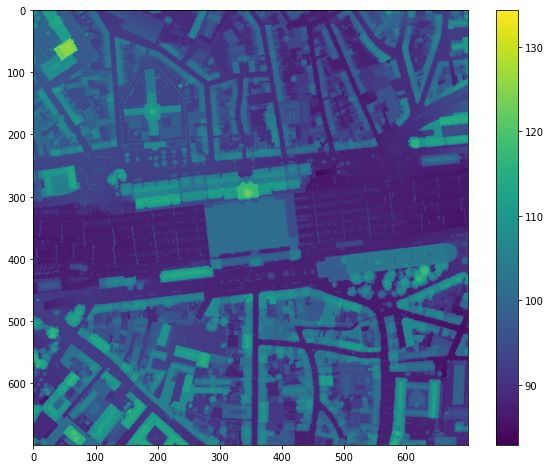

In [14]:
coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 700

print(path_dsm)

with rio.open(path_dsm) as dsm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dsm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dsm_meta = dsm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dsm)
plt.colorbar()
plt.show()

##### DTM

Pixel Y, X coords: 21186, 41046


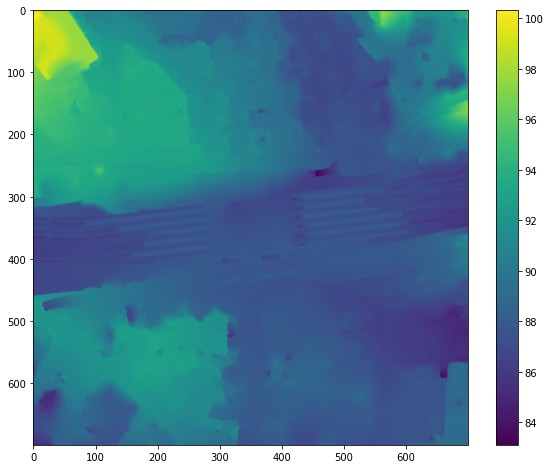

In [15]:
with rio.open(path_dtm) as dtm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dtm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dtm = dtm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dtm_meta = dtm.profile

plt.figure(figsize=(10, 8))
plt.imshow(small_dtm)
plt.colorbar()
plt.show()

## Canopy Height Model and Hillshade

DSM - DTM = CHM

In [16]:
lidar_chm = small_dsm - small_dtm

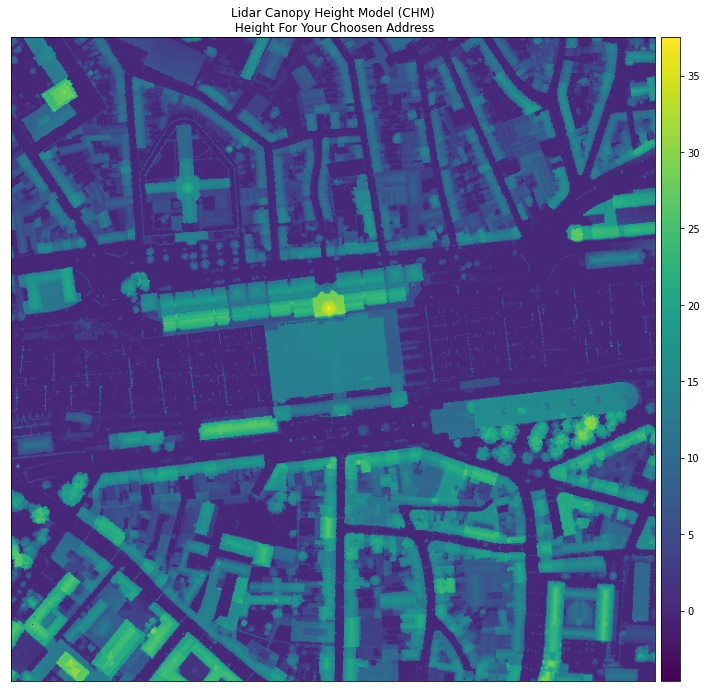

In [17]:
ep.plot_bands(lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.show()

## Cleaning

In [18]:
# CLEANUP: Set CHM values of 1 or less to NAN
clean_lidar_chm = small_dsm - small_dtm
clean_lidar_chm[clean_lidar_chm <= 1] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(lidar_chm))
print('Max:', np.nanmax(lidar_chm))
print('Min:', np.nanmin(lidar_chm))
print('_____________________')
print('Mean:', np.nanmean(clean_lidar_chm))
print('Max:', np.nanmax(clean_lidar_chm))
print('Min:', np.nanmin(clean_lidar_chm))

Mean: 6.3350453
Max: 37.489265
Min: -4.6289215
_____________________
Mean: 10.663628
Max: 37.489265
Min: 1.0000305


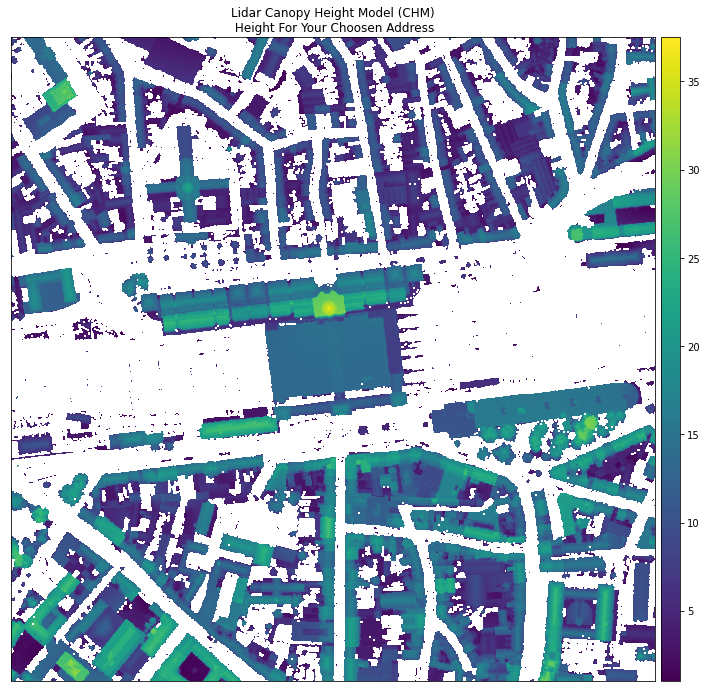

In [19]:
ep.plot_bands(clean_lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.show()

Text(0.5, 1.0, 'Lidar Canopy Height Model (CHM)')

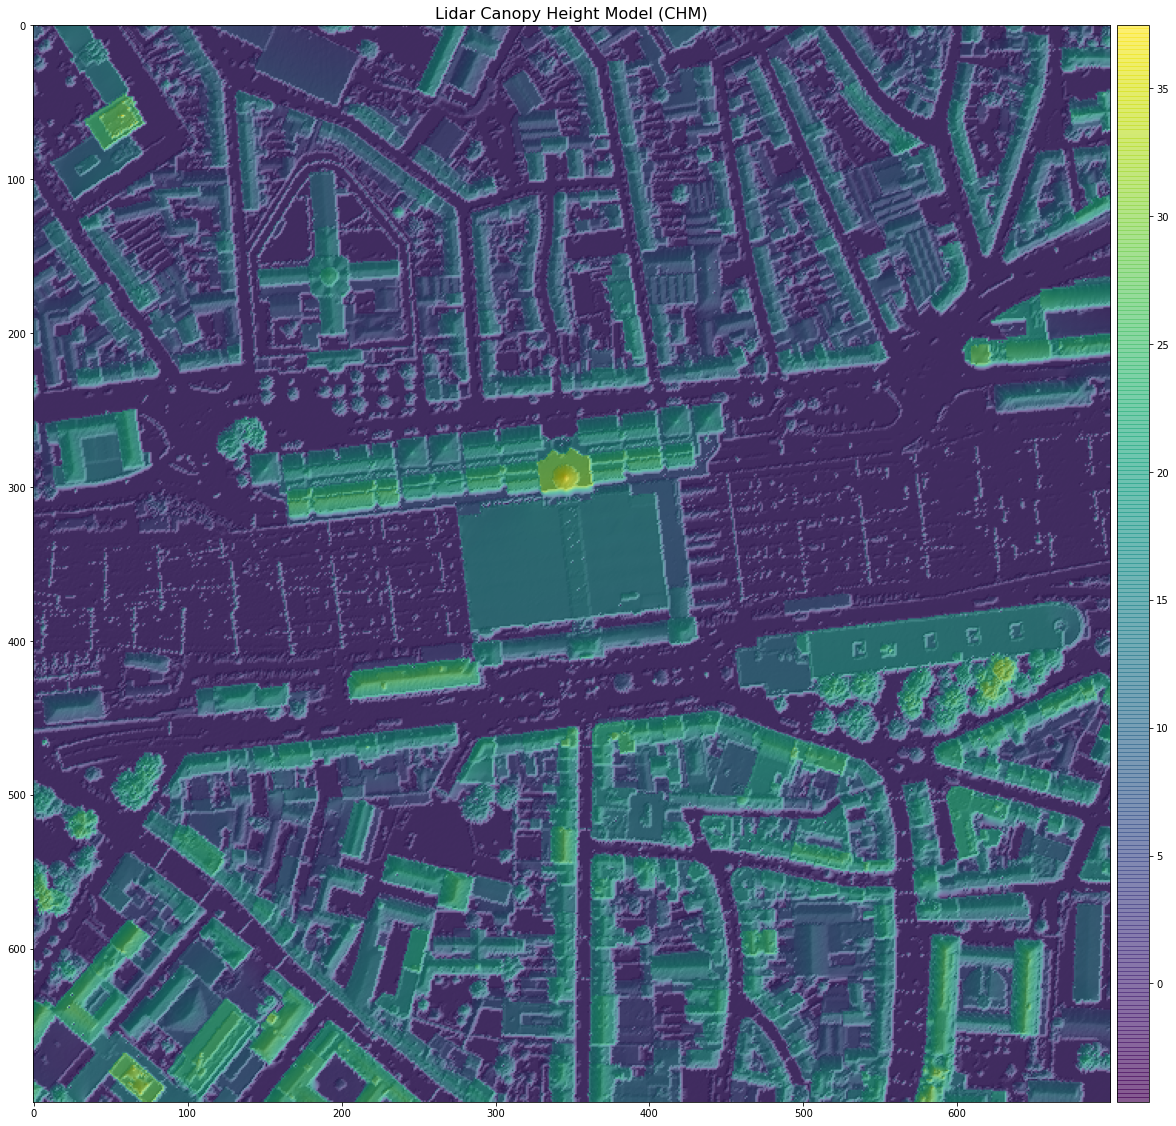

In [20]:
# create hillshade using hillshade function in earthpy
chm_hill = es.hillshade(lidar_chm, 315, 45)

# plot the data
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(chm_hill, cmap='Greys')
chm_plot = ax.imshow(lidar_chm, 
                     cmap='viridis', 
                     alpha = .65)

ep.colorbar(chm_plot)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16)



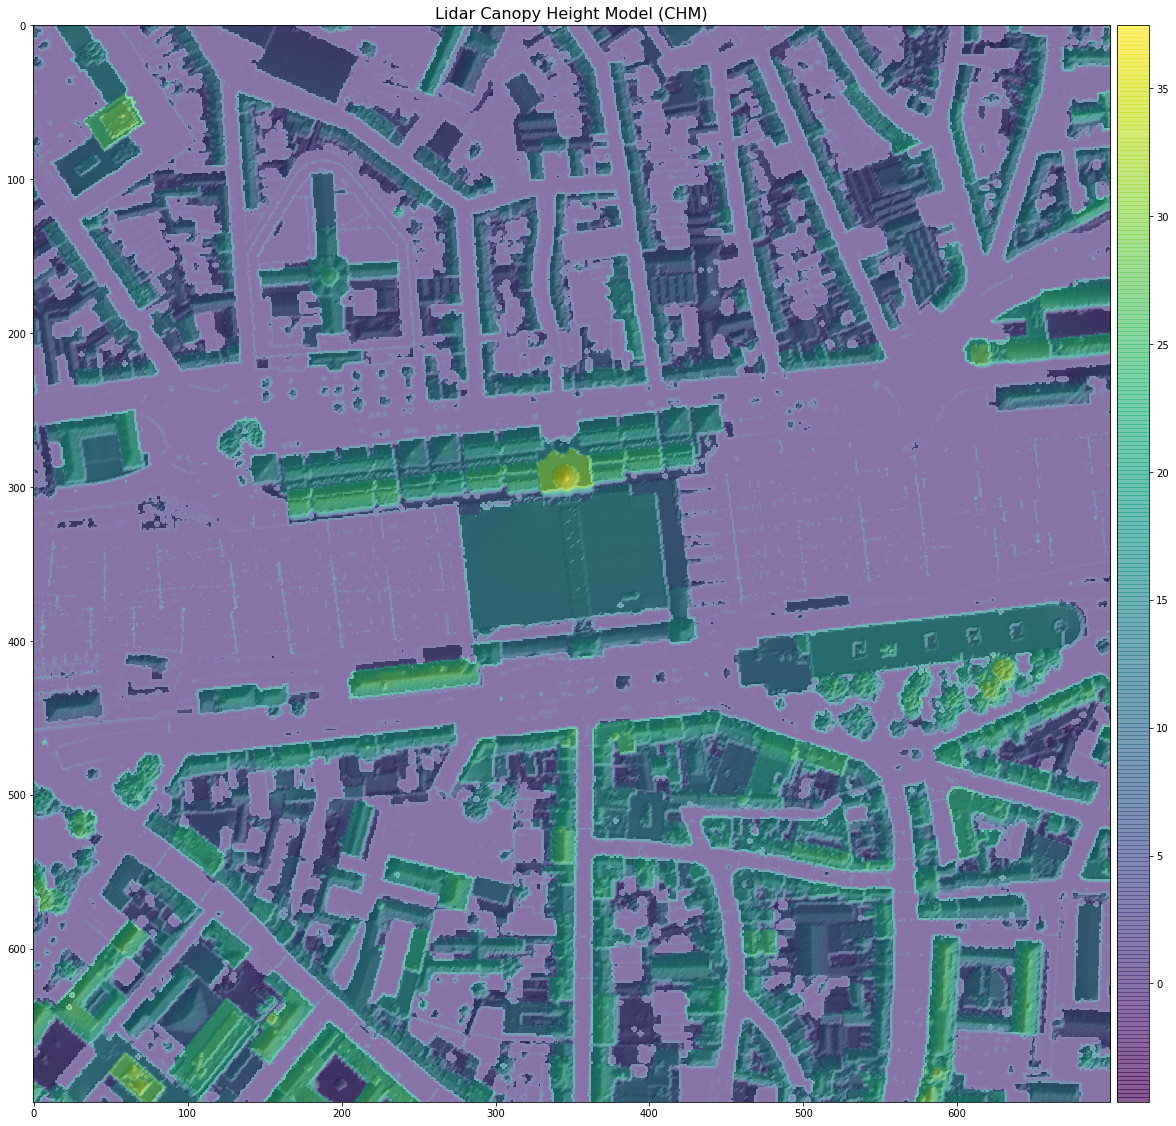

In [21]:
# create hillshade using hillshade function in earthpy
chm_hill = es.hillshade(clean_lidar_chm, 315, 45)

# plot the data
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(chm_hill, cmap='Greys')
chm_plot = ax.imshow(lidar_chm, 
                     cmap='viridis', 
                     alpha = .65)

ep.colorbar(chm_plot)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16);

In [ ]:
# Create the data.
from numpy import pi, sin, cos, mgrid
dphi, dtheta = pi/250.0, pi/250.0
[phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
x = r*sin(phi)*cos(theta)
y = r*cos(phi)
z = r*sin(phi)*sin(theta)

# View it.
from mayavi import mlab
s = mlab.mesh(x, y, z)
mlab.show()

## Saving some files

In [ ]:
with rio.open('../Outputs/small_dsm.tiff', 'w', **dsm_meta) as ff:
    ff.write(small_dsm,1)

In [ ]:
with rio.open('../Outputs/small_dtm.tiff', 'w', **dtm_meta) as ff:
    ff.write(small_dtm,1)

In [ ]:
with rio.open('../Outputs/lidar_chm.tiff', 'w', **dsm_meta) as ff:
    ff.write(lidar_chm,1)

TO DO :
    
Flandre :
    "Get the file"
    analyser shapefile pour obtenir coordonnées min/max
    selectionner les bons fichiers
    avoir le système de référence (crs)
    transformer coord das le système de référence
    
Les deux :
    Projection 3D
    Select one house only
    